Desafio realizado por Cristobal Novoa

# Desafío - Inferencia de tópicos con EM

● Para realizar este desafío debes haber estudiado previamente todo el material
disponibilizado correspondiente a la unidad.

● Una vez terminado el desafío, comprime la carpeta que contiene el desarrollo de los
requerimientos solicitados y sube el .zip en el LMS.

● Desarrollo desafío:

○ El desafío se debe desarrollar de manera Individual.

○ Para la realización del desafío necesitarás apoyarte del archivo Apoyo Desafío -
Inferencia de tópicos con EM.

# Requerimientos

● En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de
distintos artistas. Cada uno de los csv se encuentra en la carpeta dump.

● Cada csv tiene el nombre del artista a analizar. Los archivos contienen el nombre del
artista, el género musical del artista, el nombre de la canción y las letras.

● En base a esta información, el objetivo del ejercicio es generar un modelo probabilístico
que pueda identificar el género musical más probable dado la letra de una canción.

● Para ello implementaremos un modelo conocido como Latent Dirichlet Allocation que
hace uso de una variante del algoritmo EM para inferir clases latentes a partir de una
matriz de documentos.

# Ejercicio 1: Preparar el ambiente de trabajo

● Importe los módulos numpy, pandas, matplotlib, seaborn, glob y os siguiendo las
buenas prácticas. Los últimos dos módulos permitirán realizar la importación de
múltiples archivos dentro de la carpeta dump.

● Para ello genere un objeto que guarde en una lista todos los archivos alojados en dump
utilizando glob.glob y os.getcwd() para extraer las rutas absolutas. Posteriormente
genere un objeto pd.DataFrame que contenga todos los csv.

● Asegúrese de eliminar la columna Unnamed: 0 que se genera por defecto.

In [89]:
# añadimos las librerías clásicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (10, 6)
import glob
import os

In [90]:
cwd = os.getcwd()#Se genera string inicial rutas
lista_csv = glob.glob(str(cwd)+'/dump/*.csv')#Se generan rutas relativas
frames = [pd.read_csv(f) for f in lista_csv]# Se lee cada csv
result = pd.concat(frames, sort = False).drop(['Unnamed: 0'], axis=1)# Se concatenan dataframes
df = pd.DataFrame(result) #Se genera dataframe 

In [91]:
df.columns # Se revisan las columnas para cambiar sus nombre

Index(['0', '1', '2', '3'], dtype='object')

In [92]:
df = df.rename(columns={'0':'artist', '1':'musical_genre', '2': 'song', '3': 'lyrics'})#Cambio de nombres

In [93]:
df.head()

,artist,musical_genre,song,lyrics
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee..."
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...


# Ejercicio 2: Matriz de ocurrencias

● Importe la clase CountVectorizer dentro de los módulos feature_extraction.text
de la librería sklearn.

● Aplique la clase para extraer las 5000 palabras más repetidas en toda la base de datos.

● Con la clase inicializada, incorpore las letras con el método fit_transform y guarde los
resultados en un nuevo objeto.

In [94]:
# Se importa el metodo CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [95]:
count_vectorizer=CountVectorizer(stop_words='english', max_features = 5000)
count_vectorizer_fit = count_vectorizer.fit_transform(df['lyrics'])
words = count_vectorizer.get_feature_names()
words_freq = count_vectorizer_fit.toarray().sum(axis=0)

In [96]:
df_top_words = pd.DataFrame(data= {'freq': words_freq}, index = words)
by_freq = df_top_words.sort_values('freq',ascending = False)
by_freq.shape

(5000, 1)

In [97]:
#Se genera dataframe para mostrar las 10 palabras mas frecuentes
by_freq.head(10)

,freq
like,19629
don,17398
know,14962
got,14171
just,13978
love,11268
yeah,11071
ll,10028
oh,9879
cause,8356


# Ejercicio 3: Entrenamiento del Modelo

● Importe sklearn.decomposition.LatentDirichletAllocation y
sklearn.model_selection.GridSearchCV.

● Genere una búsqueda de grilla con los siguientes hiper parámetros:

○ n_components: [5, 10, 15].

○ learning_decay: [0.7, 0.5].

● Entrene la búsqueda de grilla con las letras en un formato vectorizado con
CountVectorizer.

● Reporte brevemente cuál es la mejor combinación de hiper parámetros.
Digresión: Latent Dirichlet Allocation

Latent Dirichlet Allocatio (LDA) es un modelo probabilístico generativo basado en Inferencia
Variacional EM. La principal utilidad de esto es la identificación de tópicos en un corpus de
texto. El proceso de inferencia se puede resumir en los siguientes pasos:

● Cada documento dentro del corpus se puede entender como una mezcla de tópicos
comunes a nivel de corpus.

● Esta mezcla de tópicos es latente: sólo observamos los documentos registrados y sus
palabras.

La API de sklearn.decomposition.LatentDirichletAllocation presenta la misma
funcionalidad de todo modelo de sklearn. Algunos puntos a considerar en la
inicialización de la clase son:

○ n_components: Cantidad de tópicos a inferir en un corpus.

○ learning_method: Forma en la que entran los datos en entrenamiento. Cuando
es 'batch', se ingresa la matriz de entrenamiento completa. Cuando es 'online', la
matriz de entrenamiento ingresa de manera secuencial en parcelas pequeñas.

○ learning_decay: Tasa de aprendizaje en la función de pérdida. Cuando se
implementa con learning_method='online', el modelo se entrena con
Gradiente Estocástico Descendente.

○ Perplejidad: Busca aproximar el número óptimo de tópicos a inferir.
Técnicamente evalúa qué tan bien predice una muestra específica. En función a
un número de tópicos, define la distribución teórica de palabras representada por
los tópicos y la compara con la ocurrencia empírica de palabras en tópicos.

In [98]:
#Se importan librerias
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

In [99]:
#Se genera Gridsearch para buscar los hiperparametros 
parameters = {'n_components':[5, 10, 15], 'learning_decay':[0.7, 0.5]}
lda = LatentDirichletAllocation(learning_method = 'online', random_state = 4982, n_jobs = 1)
clf = GridSearchCV(lda, param_grid= parameters)

In [100]:
clf =  GridSearchCV(lda, param_grid= parameters )

In [101]:
%%time
clf.fit(count_vectorizer_fit)

Wall time: 27min 15s


GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 n_jobs=1, random_state=4982),
             param_grid={'learning_decay': [0.7, 0.5],
                         'n_components': [5, 10, 15]})

In [102]:
#Se indica la mejor combinacion de hiperparametros
clf.best_params_

{'learning_decay': 0.7, 'n_components': 5}

# Ejercicio 4 : Inferencia e Identificación de Tópicos

● En base a la mejor combinación de hiper parámetros, entrene el modelo con la matriz de
atributos de las letras.

● Para identificar de qué se trata cada tópico, necesitamos identificar las principales 15
palabras asociadas con éste. Puede implementar la siguiente línea de código para
identificar las principales palabras en un tópico:

`for topic_id, topic_name in enumerate(fit_best_lda.components_):
    print("tópico: {}".format(topic_id + 1))
    print(" ".join([counter.get_feature_names()[i] for i in topic_name.argsort()[:-15 - 1: -1]]))`
    
● Comente a qué tópicos está asociada cada clase inferida.

In [105]:
#Se entrena el modelo en base a la mejor combinacion de hiperparametros
lda = LatentDirichletAllocation(learning_method = 'online', random_state = 4982, n_jobs = 1, n_components=5, learning_decay=0.7 )
fit_best_lda = lda.fit(count_vectorizer_fit)

In [106]:
#Se indican las 15 principales palabras por topico
for topic_id, topic_name in enumerate(fit_best_lda.components_):
    print("tópico: {}".format(topic_id + 1))
    print(" ".join([count_vectorizer.get_feature_names()[i] for i in topic_name.argsort()[:-15 - 1: -1]]))

tópico: 1
life world god time die death eyes dead ll blood soul away light live pain
tópico: 2
oh song hey sun come home ll whoa away old morning days night like moment
tópico: 3
don love know just yeah got baby ll want like let ve gonna say way
tópico: 4
yeah fuck la rock like uh ha money roll let da say come girls just
tópico: 5
like got shit yo don ain nigga know man em cause just ya niggas bitch


El topico 1 esta asociado al genero musical metal en base a las palabras indicadas por la funcion como god, time , death, blood
El topico 2 esta asociado al genero musical pop-rock con  palabras como song, sun, old, morning, moment
El topico 3 esta asociado al genero pop con palabras como love, just, yeah, got, baby
El topico 4 esta asociado al genero rock con palabras  como fuck, rock, like, money
El topico 5 esta asociado al genero hip hop con palabras como shit, nigga, man, bitch.   

# Ejercicio 5: Identificación de probabilidades

● En base a la información generada, es posible identificar cuales van a ser los géneros
más probables de ocurrir para un artista.

● Para ello necesitamos guardar la probabilidad de cada canción en nuestra base de
datos original. Podemos implementar esto de la siguiente manera:

`fit_best_lda = best_lda.transform(transformed_feats)`
`topics_for_each_doc = pd.DataFrame(np.round(fit_best_lda, 3),index=df_lyrics.index)`
`topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x),range(1, best_lda.n_components + 1)))`
`concatenated_df = pd.concat([df_lyrics, topics_for_each_doc], axis=1)`
`concatenated_df['highest_topic'] = np.argmax(docs_topics.values, axis=1) + 1` 

● Genere una matriz de correlaciones entre la probabilidad de tópicos inferidos. Comente
brevemente cuales son las principales asociaciones existentes.

● Con esta nueva base de datos, identifique las probabilidades de pertenencia para un
artista específico.

● Grafique la distribución de las probabilidades para algún artista en específico.

In [107]:
#Se genera base de datos con probabilidades
fit_best_lda = lda.transform(count_vectorizer_fit)
topics_for_each_doc = pd.DataFrame(np.round(fit_best_lda, 3),index=df.index)
topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x),range(1, lda.n_components + 1)))

In [108]:
topics_for_each_doc.head()

,T: 1,T: 2,T: 3,T: 4,T: 5
0,0.871,0.006,0.112,0.005,0.006
1,0.572,0.005,0.206,0.005,0.212
2,0.057,0.108,0.506,0.327,0.002
3,0.467,0.003,0.384,0.074,0.072
4,0.890,0.003,0.101,0.003,0.003


In [109]:
concatenated_df = pd.concat([df, topics_for_each_doc], axis=1)
#Buscando el topico con probabilidad mas alta en la matriz de topicos
concatenated_df['highest_topic'] = np.argmax(topics_for_each_doc.values, axis=1) + 1 

In [110]:
#Se muestra base de datos concatenada
concatenated_df.head()

,artist,musical_genre,song,lyrics,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee...",0.871,0.006,0.112,0.005,0.006,1
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...,0.572,0.005,0.206,0.005,0.212,1
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...,0.057,0.108,0.506,0.327,0.002,3
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...,0.467,0.003,0.384,0.074,0.072,1
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...,0.890,0.003,0.101,0.003,0.003,1


<AxesSubplot:>

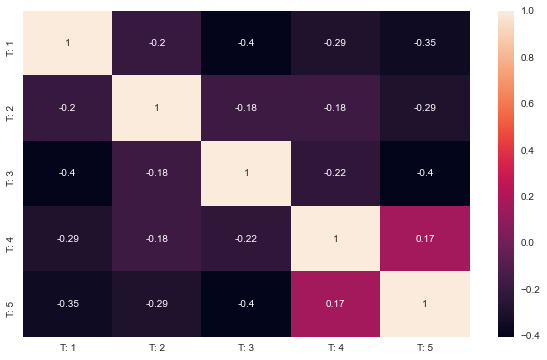

In [111]:
#Se genera matriz de correlaciones entre topicos
corr = topics_for_each_doc.corr()
sns.heatmap(data =corr, annot= True)

Las principales correlaciones son entre el topico 3 y 5 y entre el topico 1 y 3, aunque en general las correlaciones tienen valores bastante bajos, lo que indica que muestra una indepencia clara entre los topicos.  

In [112]:
concatenated_df.columns

Index(['artist', 'musical_genre', 'song', 'lyrics', 'T: 1', 'T: 2', 'T: 3',
       'T: 4', 'T: 5', 'highest_topic'],
      dtype='object')

In [113]:
#Se identifican probabilidades de pertenencia para Anthrax
set_ant = concatenated_df[concatenated_df['artist'] == 'Anthrax']

In [114]:
#Se reportan probabilidades de pertenencia para Anthrax
group_topic= set_ant['highest_topic'].value_counts('%').round(2)
group_topic

1    0.56
3    0.25
2    0.07
4    0.06
5    0.05
Name: highest_topic, dtype: float64

Text(0.5, 1.0, 'Distribucion de probabilidades Anthrax')

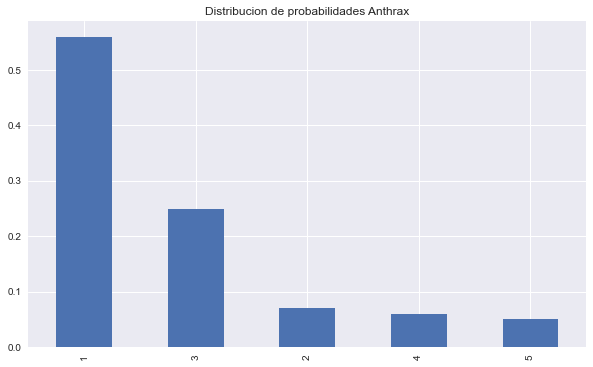

In [115]:
#Se genera grafica de distribucion de probabilidades para Anthrax
group_topic.plot.bar()
plt.title('Distribucion de probabilidades Anthrax')